In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix,confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score,f1_score, precision_recall_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier

In [2]:
df_engagement = pd.read_csv(r"C:\Users\matmi\OneDrive\Documents\Springboard_GitHub\1481069814_relax_challenge\relax_challenge\takehome_user_engagement.csv")
df_users = pd.read_csv(r"C:\Users\matmi\OneDrive\Documents\Springboard_GitHub\1481069814_relax_challenge\relax_challenge\takehome_users.csv")

In [3]:
df_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
df_engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [6]:
df_users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [7]:
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [8]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [9]:
df_engagement['time_stamp'] = pd.to_datetime(df_engagement['time_stamp'])
df_users['creation_time'] = pd.to_datetime(df_users['creation_time'])

In [10]:
df_engagement.set_index('time_stamp', inplace=True)

In [11]:
len(df_engagement)/len(df_users)

17.326416666666667

In [12]:
def find_adopted_users(user_id):
    """
    Function to determine if a user has logged into the product three times within a 7 day span.
    """
    df = df_engagement[df_engagement["user_id"] == user_id]
    adopted_user=0
    # find the difference between the day in the loop and the third date after and determine if it is <= a 7 day timedelta
    for i in range(len(df) - 2):
        if df.index[i+2] - df.index[i] <= timedelta(days=7):
            adopted_user = 1
            break
        else:
            adopted_user = 0
            
    return adopted_user

In [13]:
df_users['adopted_user'] = df_users['object_id'].apply(find_adopted_users)

In [14]:
df_users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0


In [15]:
df_users['adopted_user'][df_users['adopted_user'] == 1].groupby([df_users.creation_time.dt.year, df_users.creation_time.dt.month]).agg('count')

creation_time  creation_time
2012           5                 2
               6                73
               7                60
               8                68
               9                68
               10               69
               11               65
               12               63
2013           1                58
               2                72
               3                69
               4                70
               5                60
               6                80
               7                63
               8                77
               9                74
               10               93
               11               86
               12               73
2014           1                92
               2                65
               3                95
               4                45
               5                16
Name: adopted_user, dtype: int64

In [16]:
print("Percent of adopted users: ", sum(df_users.adopted_user) / len(df_users) * 100, "%")

Percent of adopted users:  13.8 %


In [17]:
df_users.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                     0
dtype: int64

In [18]:
df_users.invited_by_user_id.fillna(0, inplace=True)

In [19]:
df_users.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id               0
adopted_user                     0
dtype: int64

In [20]:
df_model = df_users.drop(columns=['last_session_creation_time', 'object_id', 'creation_time', 'name', 'email'])

In [21]:
df_model = pd.get_dummies(df_model)

In [22]:
df_model.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803.0,0,1,0,0,0,0
1,0,0,1,316.0,1,0,1,0,0,0
2,0,0,94,1525.0,0,0,1,0,0,0
3,0,0,1,5151.0,0,1,0,0,0,0
4,0,0,193,5240.0,0,1,0,0,0,0


## Predictive Modelling

In [23]:
# Split train/test data 

X = df_model.drop(columns=['adopted_user'])
y = df_model.adopted_user

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [24]:
X.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [25]:
#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)

#### RandomForest

In [26]:
rf_class = RandomForestClassifier(random_state=18)
params = {'n_estimators'      : [50],
          'max_features'      : [3, 6, 9],
          'max_depth'         : [x for x in range(5, 20, 5)],
          'min_samples_leaf'  : [x for x in range(100, 1000, 100)]
         }

rf_model = GridSearchCV(estimator=rf_class, param_grid=params, cv=5)
rf_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=18),
             param_grid={'max_depth': [5, 10, 15], 'max_features': [3, 6, 9],
                         'min_samples_leaf': [100, 200, 300, 400, 500, 600, 700,
                                              800, 900],
                         'n_estimators': [50]})

In [27]:
print("Best Parameters for RandomForestClassifier       : ", rf_model.best_params_)
print("\n")
print("Best average accuracy for RandomForestClassifier :", rf_model.best_score_)

Best Parameters for RandomForestClassifier       :  {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 100, 'n_estimators': 50}


Best average accuracy for RandomForestClassifier : 0.8644444444444443


In [28]:
rf_model = RandomForestClassifier(**rf_model.best_params_)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2564
           1       0.00      0.00      0.00       436

    accuracy                           0.85      3000
   macro avg       0.43      0.50      0.46      3000
weighted avg       0.73      0.85      0.79      3000



C:\Users\matmi\anaconda_3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matmi\anaconda_3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matmi\anaconda_3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
roc_auc_score(y_test,y_pred_rf)

0.5

In [30]:
y_pred_rf_p = rf_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred_rf_p)

0.5739969621720649

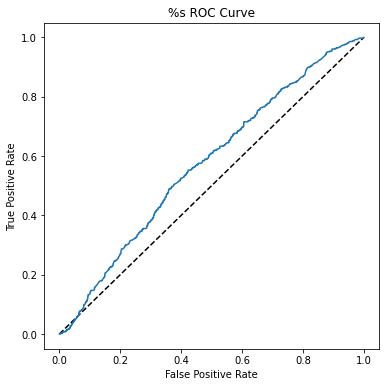

In [31]:
fpr, tpr, thresholds  = roc_curve(y_test, y_pred_rf_p)
plt.figure(figsize=(6,6))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve')
plt.show()


Confusion matrix


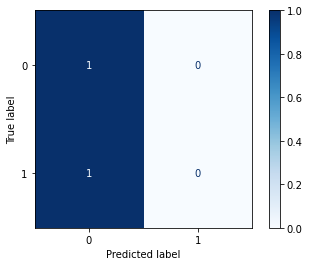

In [32]:
print("Confusion matrix")
plot_confusion_matrix(rf_model, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
plt.show()


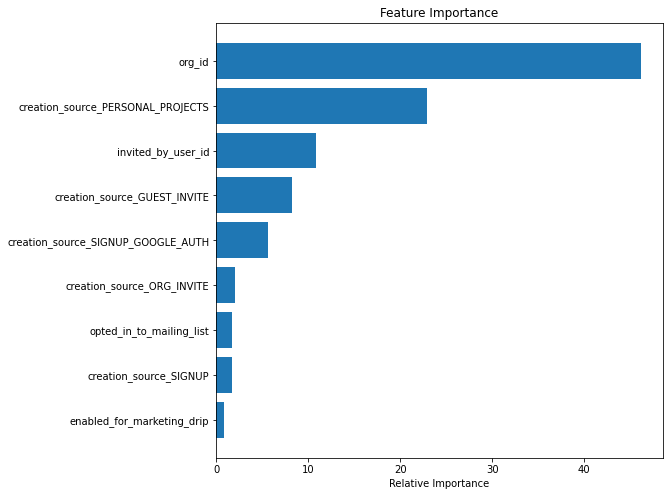

In [33]:
feature_import = rf_model.feature_importances_[:len(X_train)]
feature_import = feature_import*100

sorted_idx = np.argsort(feature_import)
pos = np.arange(sorted_idx.shape[0])
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_import[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

**ANSWER:**

The organizational ID of the user is the most relevant feature in the group, followed by the Personal Projects creation source and who the user was invited by. It would be interesting to better understand which organizations are most responsible for contributing to adopted users and which users best invited users who would become adopted users. Finally, targeting people interested in creating personal projects could be an interesting way of continuing to attract adopted users. 

However, the model is performing very poorly with respect to the baseline. It is simply predicting that the user will not be adopted in each case to maintain a high accuracy score. It has recognized that only ~13.8% of the users become adopted users.  